In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load dataset
df = pd.read_csv('lifestyle.csv')  # Replace with your file path

# 2. Basic info
print("Data shape:", df.shape)
print(df.head())

Data shape: (20000, 27)
          Income  Age  Dependents     Occupation City_Tier          Rent  \
0   44637.249636   49           0  Self_Employed    Tier_1  13391.174891   
1   26858.596592   34           2        Retired    Tier_2   5371.719318   
2   50367.605084   35           1        Student    Tier_3   7555.140763   
3  101455.600247   21           0  Self_Employed    Tier_3  15218.340037   
4   24875.283548   52           4   Professional    Tier_2   4975.056710   

   Loan_Repayment    Insurance     Groceries    Transport  ...  \
0        0.000000  2206.490129   6658.768341  2636.970696  ...   
1        0.000000   869.522617   2818.444460  1543.018778  ...   
2     4612.103386  2201.800050   6313.222081  3221.396403  ...   
3     6809.441427  4889.418087  14690.149363  7106.130005  ...   
4     3112.609398   635.907170   3034.329665  1276.155163  ...   

   Desired_Savings  Disposable_Income  Potential_Savings_Groceries  \
0      6200.537192       11265.627707               

In [3]:
# 3. Define numerical and categorical columns
numerical_cols = ['Income', 'Age', 'Dependents', 'Rent', 'Loan_Repayment', 'Insurance',
                  'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
                  'Healthcare', 'Education', 'Miscellaneous', 'Desired_Savings_Percentage',
                  'Desired_Savings', 'Disposable_Income',
                  'Potential_Savings_Groceries', 'Potential_Savings_Transport',
                  'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment',
                  'Potential_Savings_Utilities', 'Potential_Savings_Healthcare',
                  'Potential_Savings_Education', 'Potential_Savings_Miscellaneous']

categorical_cols = ['Occupation', 'City_Tier']

# 4. Preprocessing pipelines
# Numerical pipeline: impute missing values with mean + scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values with most frequent + one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

In [4]:
# 5. Preprocess data
X_processed = preprocessor.fit_transform(df)

print("Shape after preprocessing:", X_processed.shape)

Shape after preprocessing: (20000, 32)


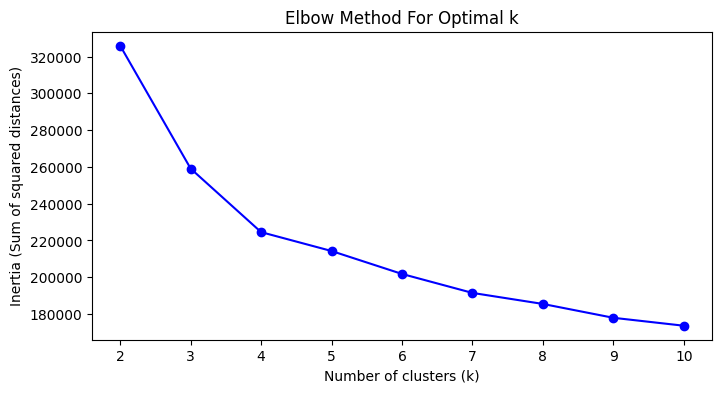

In [5]:
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

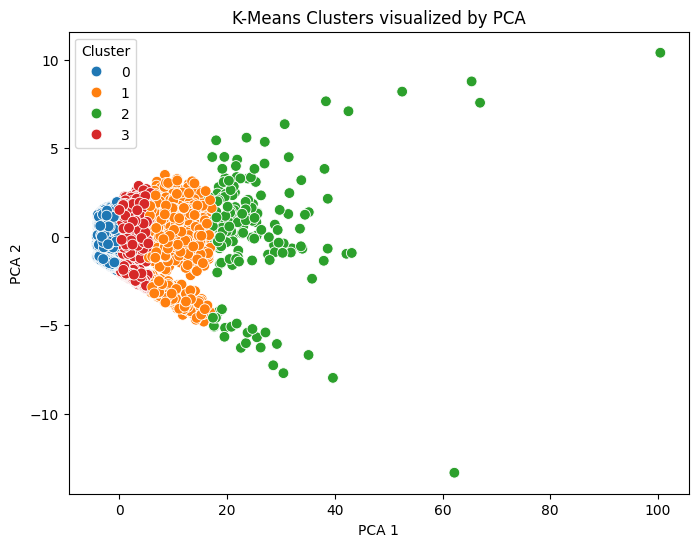

In [6]:
# 7. Fit KMeans with chosen k (replace k_optimal with your chosen k)
k_optimal = 4  # example, adjust after elbow plot inspection
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# Add cluster labels to original dataframe
df['Cluster'] = clusters

# 8. PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10', s=60)
plt.title('K-Means Clusters visualized by PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [7]:
# 9. Cluster profiling: mean values of key variables per cluster
profile_cols = ['Income', 'Age', 'Transport', 'Loan_Repayment', 'Desired_Savings_Percentage', 'Disposable_Income']

cluster_profile = df.groupby('Cluster')[profile_cols].mean().round(2)
print("\nCluster Profiling:")
print(cluster_profile)



Cluster Profiling:
            Income    Age  Transport  Loan_Repayment  \
Cluster                                                
0         21534.44  40.97    1399.46         1074.32   
1        127938.06  40.71    8340.90         6344.79   
2        278825.42  39.83   18193.35        12957.80   
3         60106.66  41.29    3904.58         2948.10   

         Desired_Savings_Percentage  Disposable_Income  
Cluster                                                 
0                              7.53            5515.41  
1                             19.27           32977.18  
2                             20.30           68729.37  
3                             12.48           15414.82  


In [8]:
# Step 10 - Enhanced Interpretation and Ranking of Clusters

# Select columns relevant for target profiling
target_metrics = ['Income', 'Transport', 'Loan_Repayment', 'Age', 'Desired_Savings_Percentage', 'Disposable_Income']

# Calculate mean values per cluster for target metrics
cluster_profile = df.groupby('Cluster')[target_metrics].mean().round(2)

# Normalize these metrics to 0-1 scale for fair ranking (higher is better except Loan_Repayment)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize all except Loan_Repayment (since lower loan burden is better, invert it)
metrics_for_scaling = cluster_profile.drop(columns=['Loan_Repayment'])

scaled_metrics = pd.DataFrame(scaler.fit_transform(metrics_for_scaling),
                              columns=metrics_for_scaling.columns,
                              index=cluster_profile.index)

# For Loan_Repayment invert the scale (lower better)
loan_scaled = 1 - (cluster_profile['Loan_Repayment'] - cluster_profile['Loan_Repayment'].min()) / (cluster_profile['Loan_Repayment'].max() - cluster_profile['Loan_Repayment'].min())

# Combine scaled metrics and inverted loan repayment
scaled_metrics['Loan_Repayment'] = loan_scaled

# Calculate a simple composite score as average of all scaled metrics
scaled_metrics['Composite_Score'] = scaled_metrics.mean(axis=1)

# Sort clusters by Composite_Score descending
ranked_clusters = scaled_metrics.sort_values(by='Composite_Score', ascending=False)

print("Cluster Ranking based on EV early adopter criteria (higher is better):\n")
print(ranked_clusters[['Composite_Score']])

print("\nCluster Profiles for reference:\n")
print(cluster_profile.loc[ranked_clusters.index])


Cluster Ranking based on EV early adopter criteria (higher is better):

         Composite_Score
Cluster                 
2               0.666667
1               0.556647
3               0.447606
0               0.296804

Cluster Profiles for reference:

            Income  Transport  Loan_Repayment    Age  \
Cluster                                                
2        278825.42   18193.35        12957.80  39.83   
1        127938.06    8340.90         6344.79  40.71   
3         60106.66    3904.58         2948.10  41.29   
0         21534.44    1399.46         1074.32  40.97   

         Desired_Savings_Percentage  Disposable_Income  
Cluster                                                 
2                             20.30           68729.37  
1                             19.27           32977.18  
3                             12.48           15414.82  
0                              7.53            5515.41  


Cleaned Columns: ['age', 'profession', 'marrital_status', 'education', 'no_of_dependents', 'personal_loan', 'house_loan', 'wife_working', 'salary', 'wife_salary', 'total_salary', 'make', 'price']
Processed shape: (99, 28)


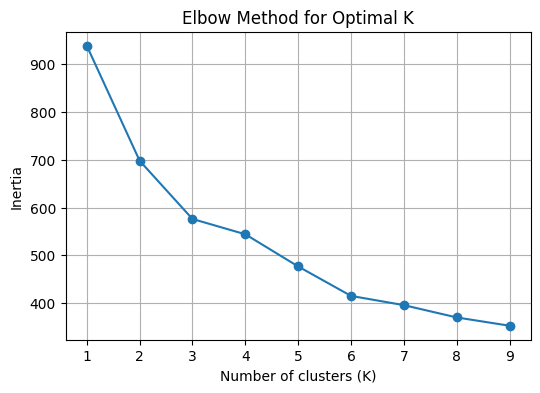

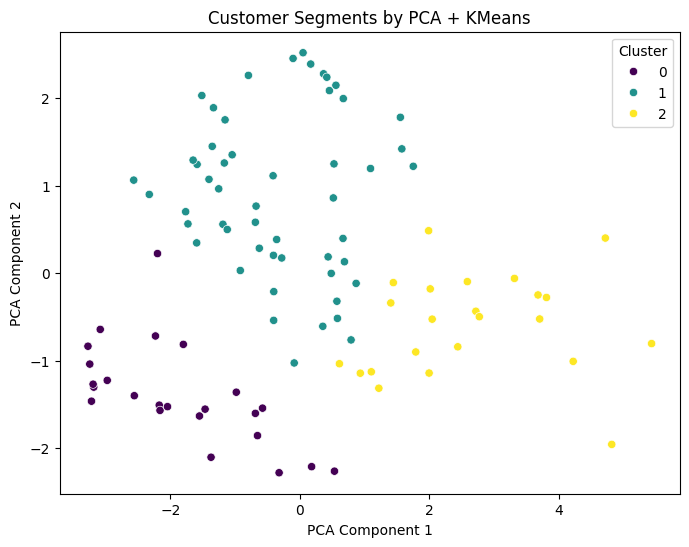


Cluster Summary:
               age  no_of_dependents        salary   wife_salary  \
cluster                                                            
0        29.458333          0.166667  1.233333e+06  2.583333e+05   
1        37.807692          2.961538  1.690385e+06  2.769231e+05   
2        40.086957          2.521739  2.365217e+06  1.404348e+06   

         total_salary         price  
cluster                              
0        1.491667e+06  1.071250e+06  
1        1.967308e+06  1.036538e+06  
2        3.769565e+06  1.678261e+06  


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 1: Load the dataset
df = pd.read_csv("buying_behav.csv")

# Optional: Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
print("Cleaned Columns:", df.columns.tolist())

# Step 2: Define columns
numerical_cols = ['age', 'no_of_dependents', 'salary', 'wife_salary', 'total_salary', 'price']
categorical_cols = ['profession', 'marrital_status', 'education', 'personal_loan', 'house_loan', 'wife_working', 'make']

# Step 3: Define pipelines for preprocessing
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Step 4: Apply preprocessing
X_processed = preprocessor.fit_transform(df)
print("Processed shape:", X_processed.shape)

# Step 5: Determine optimal k using Elbow Method
inertia = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_processed)
    inertia.append(km.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Step 6: Apply KMeans with selected k (e.g., k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# Add cluster labels to original dataframe
df['cluster'] = clusters

# Step 7: Reduce dimensions for visualization (PCA)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_processed)
df['pca1'] = reduced_data[:, 0]
df['pca2'] = reduced_data[:, 1]

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='viridis')
plt.title("Customer Segments by PCA + KMeans")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Step 8: Interpret clusters
cluster_summary = df.groupby('cluster')[numerical_cols].mean()
print("\nCluster Summary:")
print(cluster_summary)


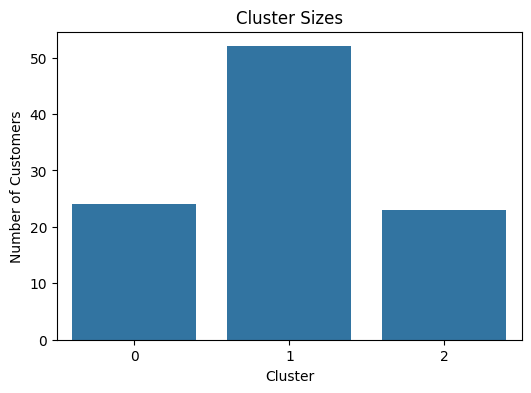

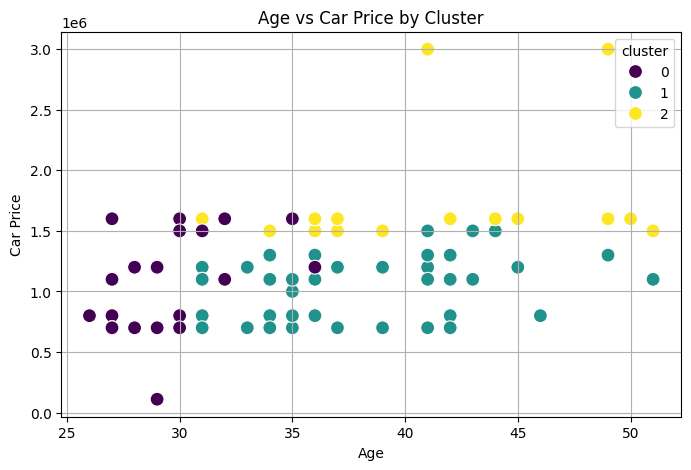

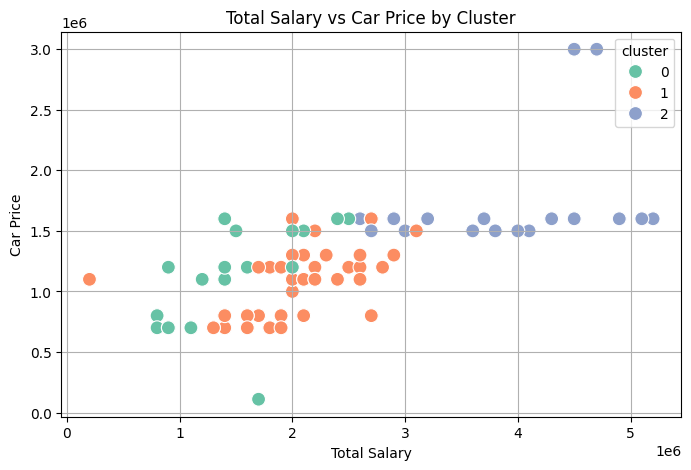

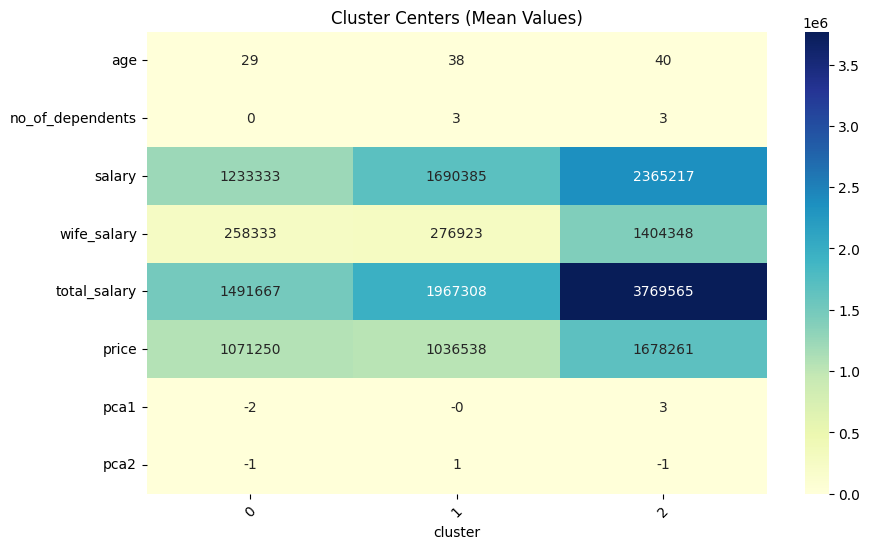

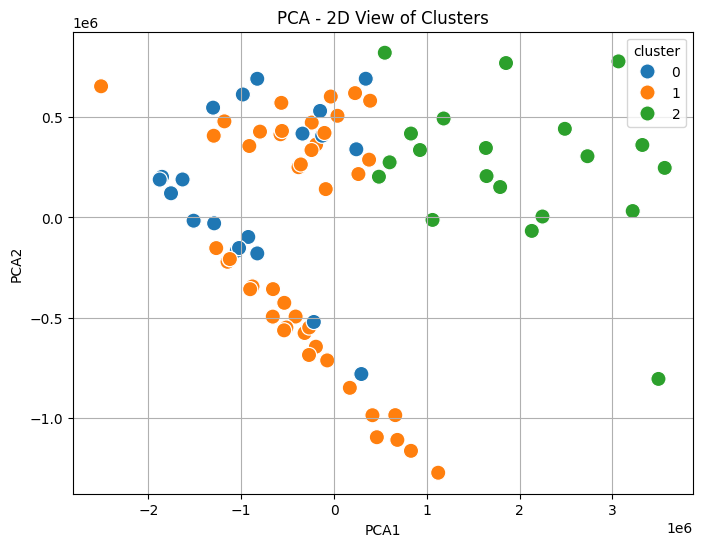

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# If not already in your df:
# df['cluster'] = cluster_labels  # Uncomment if you haven't added cluster labels yet

# ------------------------
# 1. Cluster Size
# ------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='cluster', data=df)
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

# ------------------------
# 2. Age vs Car Price
# ------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='age', y='price', hue='cluster', palette='viridis', s=100)
plt.title("Age vs Car Price by Cluster")
plt.xlabel("Age")
plt.ylabel("Car Price")
plt.grid(True)
plt.show()

# ------------------------
# 3. Total Salary vs Car Price
# ------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='total_salary', y='price', hue='cluster', palette='Set2', s=100)
plt.title("Total Salary vs Car Price by Cluster")
plt.xlabel("Total Salary")
plt.ylabel("Car Price")
plt.grid(True)
plt.show()

# ------------------------
# 4. Cluster Heatmap (Means)
# ------------------------
cluster_summary = df.groupby('cluster').mean(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary.T, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Cluster Centers (Mean Values)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# ------------------------
# 5. PCA Plot (2D)
# ------------------------
# Drop cluster & categorical columns before PCA
df_num = df.drop(['cluster'], axis=1).select_dtypes(include='number')
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_num)
df['PCA1'] = pca_data[:,0]
df['PCA2'] = pca_data[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df, palette='tab10', s=120)
plt.title("PCA - 2D View of Clusters")
plt.grid(True)
plt.show()
